In [2]:
from LSTM import LSTM
import torch
import numpy as np 
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable


In [3]:
################
#  DATALOADING #
################

In [4]:

def sliding_windows(x_data,y_data,seq_length):
    x = []
    y = []

    for i in range(len(y_data)-seq_length-1):
        _x = x_data[i:(i+seq_length)]
        _y = y_data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)



In [5]:

y_data = np.load('midprices.npy')
x_data = np.load('latent.npy')

#Reshaping data and seperating training and test set
sc_x = MinMaxScaler()
x_data = sc_x.fit_transform(x_data.squeeze(axis = 0))

sc_y = MinMaxScaler()
y_data = sc_y.fit_transform(y_data.reshape(-1,1))




seq_length = 4
x, y = sliding_windows(x_data,y_data, seq_length)





train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))


testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))



In [6]:
num_epochs = 2000
learning_rate = 1e-3

input_size = 17
hidden_size = 256
num_layers = 1
seq_length = 4
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length, fc1_out = 128)

lstm.load_state_dict(torch.load('../Models/state2-regression'))


<All keys matched successfully>

In [ ]:
print("hey")
test_hist = []
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

for epoch in range(num_epochs):

        outputs = lstm(trainX)

        optimizer.zero_grad()
    
    # obtain the loss function
        loss = criterion(outputs, trainY)
    
        loss.backward()
    
        optimizer.step()
        if testX is not None:
            with torch.no_grad():
                y_test_pred = lstm(testX)
                test_loss = criterion(y_test_pred.float(), testY)
                test_hist.append( test_loss.item())
        if epoch % 5 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(), test_hist[epoch]))

Before
After


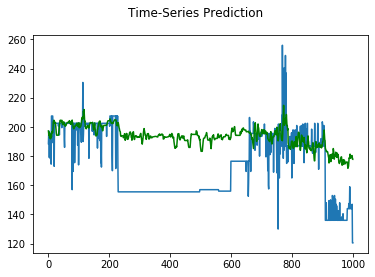

In [10]:
import matplotlib.pyplot as plt

lstm.eval()
print("Before")
size = train_size+test_size
train_predict = lstm(dataX[size-1000:size])
print("After")
data_predict = train_predict.data.numpy()[0:1000]
dataY_plot = dataY.data.numpy()[size-1000:size]
data_predict = sc_y.inverse_transform(data_predict)
dataY_plot = sc_y.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict, c='green')
plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
torch.save(lstm.state_dict(), '../Models/state2-regression')

In [ ]:
import pickle
with open('sc_midprice', 'wb') as f:
    pickle.dump(sc_y, f)
    